# Jonathan Halverson
# Saturday, February 10, 2018
# Home prices in California in Spark 2

In this notebook we perform linear regression and RF on some home prices.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()

In [3]:
housing_raw = spark.read.csv('Sacramentorealestatetransactions.csv', inferSchema=True, header=True)
housing_raw.show(5)

+----------------+----------+-----+-----+----+-----+------+-----------+--------------------+-----+---------+-----------+
|          street|      city|  zip|state|beds|baths|sq__ft|       type|           sale_date|price| latitude|  longitude|
+----------------+----------+-----+-----+----+-----+------+-----------+--------------------+-----+---------+-----------+
|    3526 HIGH ST|SACRAMENTO|95838|   CA|   2|    1|   836|Residential|Wed May 21 00:00:...|59222|38.631913|-121.434879|
|     51 OMAHA CT|SACRAMENTO|95823|   CA|   3|    1|  1167|Residential|Wed May 21 00:00:...|68212|38.478902|-121.431028|
|  2796 BRANCH ST|SACRAMENTO|95815|   CA|   2|    1|   796|Residential|Wed May 21 00:00:...|68880|38.618305|-121.443839|
|2805 JANETTE WAY|SACRAMENTO|95815|   CA|   2|    1|   852|Residential|Wed May 21 00:00:...|69307|38.616835|-121.439146|
| 6001 MCMAHON DR|SACRAMENTO|95824|   CA|   2|    1|   797|Residential|Wed May 21 00:00:...|81900| 38.51947|-121.435768|
+----------------+----------+---

In [5]:
from pyspark.sql.functions import to_timestamp

housing_raw = housing_raw.withColumn('sale_date', to_timestamp('sale_date', 'EEE MMM d H:mm:ss z yyyy'))

In [6]:
housing_raw.printSchema()

root
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- sq__ft: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- price: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [9]:
housing_raw.groupBy('sale_date').count().show()

+-------------------+-----+
|          sale_date|count|
+-------------------+-----+
|2008-05-19 00:00:00|  268|
|2008-05-21 00:00:00|  158|
|2008-05-15 00:00:00|  118|
|2008-05-16 00:00:00|  264|
|2008-05-20 00:00:00|  177|
+-------------------+-----+



In [10]:
housing_raw.select('beds', 'baths', 'sq__ft', 'price', 'latitude').describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|              beds|             baths|            sq__ft|             price|           latitude|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               985|               985|               985|               985|                985|
|   mean|2.9116751269035532|1.7766497461928934|1314.9167512690356|234144.26395939087| 38.607732086294504|
| stddev|1.3079322320435807|0.8953714223186463| 853.0482425034448|138365.83908492787|0.14543287915296987|
|    min|                 0|                 0|                 0|              1551|          38.241514|
|    max|                 8|                 5|              5822|            884790|          39.020808|
+-------+------------------+------------------+------------------+------------------+-------------------+



In [23]:
housing_raw.count()

985

In [27]:
housing_raw.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
street       985 non-null object
city         985 non-null object
zip          985 non-null int64
state        985 non-null object
beds         985 non-null int64
baths        985 non-null int64
sq__ft       985 non-null int64
type         985 non-null object
sale_date    985 non-null datetime64[ns]
price        985 non-null int64
latitude     985 non-null float64
longitude    985 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 92.4+ KB


(array([  53.,   28.,   53.,  108.,  123.,  125.,  130.,   80.,   74.,
          55.,   35.,   32.,   24.,   17.,   11.,    6.,   12.,    6.,
           2.,    6.,    0.,    1.,    0.,    2.,    2.]),
 array([   1551.  ,   36880.56,   72210.12,  107539.68,  142869.24,
         178198.8 ,  213528.36,  248857.92,  284187.48,  319517.04,
         354846.6 ,  390176.16,  425505.72,  460835.28,  496164.84,
         531494.4 ,  566823.96,  602153.52,  637483.08,  672812.64,
         708142.2 ,  743471.76,  778801.32,  814130.88,  849460.44,  884790.  ]),
 <a list of 25 Patch objects>)

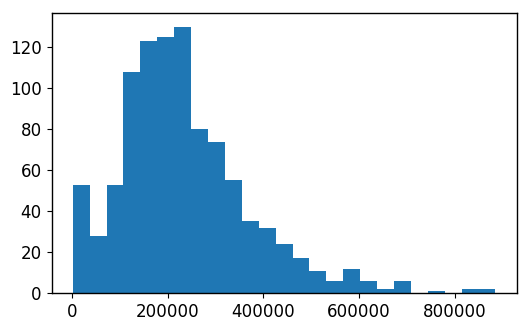

In [26]:
plt.hist(housing_raw.select('price').toPandas().values, bins=25)

We see in the table above that there are zero min values. Let's remove all homes with a zero:

In [ ]:
df = df[df.baths > 0]
df = df[df.beds > 0]
df = df[df.sqft > 0]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [ ]:
pf = df.toPandas()

In [ ]:
plt.plot(pf['sqft'], pf['price'], 'wo')
plt.xlabel('Square feet')
plt.ylabel('Price')

### Machine learning model

In [ ]:
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint

In [ ]:
df = df.select('price','baths','beds','sqft')
data_features = df.map(lambda x: x[1:])
data_features.take(5)

In [ ]:
from pyspark.mllib.feature import StandardScaler
stdsc = StandardScaler(withMean=False, withStd=True).fit(data_features)
data_features_std = stdsc.transform(data_features)

In [ ]:
from pyspark.mllib.stat import Statistics
data_features_std_stats = Statistics.colStats(data_features_std)
print 'train means:', data_features_std_stats.mean()
print 'train variances:', data_features_std_stats.variance()

In [ ]:
transformed_data = df.map(lambda x: x[0]).zip(data_features_std)
transformed_data = transformed_data.map(lambda x: LabeledPoint(x[0], [x[1]]))
transformed_data.take(5)

Perform a train-test split:

In [ ]:
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
linearModel = LinearRegressionWithSGD.train(train_data, iterations=1000, step=0.25, intercept=False)
print linearModel.weights

Note below that a LabeledPoint has features and label data members:

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
prediObserRDDin = train_data.map(lambda row: (float(linearModel.predict(row.features[0])), row.label))
metrics = RegressionMetrics(prediObserRDDin)
print metrics.r2

In [ ]:
prediObserRDDout = test_data.map(lambda row: (float(linearModel.predict(row.features[0])), row.label))
metrics = RegressionMetrics(prediObserRDDout)
print metrics.rootMeanSquaredError